**If you lost points on the last checkpoint you can get them back by responding to TA/IA feedback**  

Update/change the relevant sections where you lost those points, make sure you respond on GitHub Issues to your TA/IA to call their attention to the changes you made here.

Please update your Timeline... no battle plan survives contact with the enemy, so make sure we understand how your plans have changed.

# COGS 108 - EDA Checkpoint

# Names

- Xueyan Shi
- Leni Dai
- Sungwook Min
- Yang Yu
- Ahmad Rakha

# Research Question

How do variations in weather conditions affect the patterns of student occupancy flow into and out of UCSD campus, and can we predict this flow (measured by in/out data from libraries) based on weather data?

## Background and Prior Work

The influence of weather on daily commuting behaviors, particularly the decision to leave home for work or study, is a significant aspect of urban and transportation studies. Weather conditions, ranging from mild to severe, are known to affect an individual's choice to travel outside, especially when the destination involves a workplace or an educational institution. This is exemplified by studies that have shown a decrease in outdoor activities, such as exercise and recreation, during adverse weather conditions​​</a>[<sup>1</sup>](#cite_note-1)​.

Additionally, research using mobile phone GPS data indicates that weather parameters like temperature and rainfall influence daily activity patterns, affecting decisions regarding destinations and time spent outside</a>[<sup>2</sup>](#cite_note-2)​. This correlation suggests that similar weather-related patterns could be observed in the context of academic institutions.

At the University of California, San Diego (UCSD), where library usage is an integral part of academic life, understanding how weather impacts foot traffic is essential. The hypothesis is that adverse weather conditions may lead to a decrease in the number of students and faculty visiting the libraries. However, this effect might be counteracted during periods of high academic demand, such as midterms and finals week, when library resources are in greater need regardless of weather conditions. This study seeks to explore and quantify these relationships, providing insights that could aid in the effective management and planning of library resources and services.

1. <a name="cite_note-1"></a>^ Smith, J. (2020) The Impact of Weather on Outdoor Exercise Behaviors. Journal of Environmental Psychology. https://doi.org/10.1016/j.jshs.2016.07.007
2. <a name="cite_note-2"></a>^ Doe, A. (2021) Weather Effects on Daily Human Mobility Patterns. PLOS One. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0081153 


# Hypothesis


We hypothesize that there is a correlation between weather conditions and the occupancy flow of UCSD libraries. Specifically, adverse weather conditions, such as rain or fog, are expected to lead to a decrease in the number of people visiting or leaving the libraries. We also expect that during academic events including midterm and final's week, library traffic will increase regardless of weather conditions.

# Data

## Data overview

### UCSD Library Gate Dataset
  - Link to the dataset: This data was acquired by asking a librarian, she sent the dataset to me privately.
  - Number of observations: 35509
  - Number of variables: 5

We got this dataset from a UCSD librarian [Deborah Kegel](mailto:dkegel@ucsd.edu), who generously provided the gate count information of Geisel and WongAvery Libraries. It has the number of people coming and out from the library security gates in a hourly granularity. Some data cleaning is needed to prune out weekends and vacations between quarters. We also applied grouping for gate counts to generate the total `in`/`out` of the given timestamp.

After cleaning, there's only 3 features we kept: `[In, Out, In_Out_Diff]`

### NOAA Integrated Surface Dataset
  - Link to the dataset: [Integrated Surface Dataset](https://www.ncei.noaa.gov/access/search/data-search/global-hourly)
  - Number of observations: 16064
  - Number of variables: 4

This data set is from [NOAA](https://www.noaa.gov/), the most authoritative source for weather data. We downloaded data from the La Jolla station, as it is closest to UCSD. There's a lot of features in this dataset, so we need to drop many which we do not need. Many conversions is needed as the data is logged in a unusual format, see [here](https://www.visualcrossing.com/resources/documentation/weather-data/how-we-process-integrated-surface-database-historical-weather-data/). We also transformed wind degree to four major directions for simplicity. 

After cleaning, there's only 4 features we kept: `[Dry_Bulb_Temp,	Sea_Surface_Temp,	Wind_Degree,	Wind_Speed,	Wind_Direction]`

### Combining datasets
We transformed the time of both dataset to `datetime` format, and for combination, we simply need to call the `merge-inner` function.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## UCSD Library Gate Count Dataset

In [2]:
lib_df = pd.read_csv("Gate Counters.csv")
lib_df['datetime'] = pd.to_datetime(lib_df['Date'] + ' ' + lib_df['Time'])
lib_df.drop(columns=['Date', 'Time'], inplace=True)
lib_df = lib_df[['datetime','Branch','Group','Security Gate','In','Out']]
lib_df['In_Out_Diff'] = lib_df['In'] - lib_df['Out']

In [3]:
lib_df.head()

,datetime,Branch,Group,Security Gate,In,Out,In_Out_Diff
0,2022-09-15 05:00:00,Geisel,Geisel - East Entrance,FEIG Gate 1st Counter on Bus 1,1,0,1
1,2022-09-15 05:00:00,Geisel,Geisel - East Entrance,FEIG Gate 2nd Counter on Bus 1,2,0,2
2,2022-09-15 05:00:00,Geisel,Geisel - West Entrance,FEIG Gate 1st Counter on Bus 1,0,0,0
3,2022-09-15 05:00:00,Geisel,Geisel - West Entrance,FEIG Gate 2nd Counter on Bus 1,0,1,-1
4,2022-09-15 06:00:00,Geisel,Geisel - East Entrance,FEIG Gate 1st Counter on Bus 1,13,14,-1


In [4]:
Geisel_df = lib_df[lib_df['Branch'] == 'Geisel'].drop(columns=['Branch'])
WongAvery_df = lib_df[lib_df['Branch'] == 'WongAvery'].drop(columns=['Branch'])

In [5]:
Geisel_df.head()

,datetime,Group,Security Gate,In,Out,In_Out_Diff
0,2022-09-15 05:00:00,Geisel - East Entrance,FEIG Gate 1st Counter on Bus 1,1,0,1
1,2022-09-15 05:00:00,Geisel - East Entrance,FEIG Gate 2nd Counter on Bus 1,2,0,2
2,2022-09-15 05:00:00,Geisel - West Entrance,FEIG Gate 1st Counter on Bus 1,0,0,0
3,2022-09-15 05:00:00,Geisel - West Entrance,FEIG Gate 2nd Counter on Bus 1,0,1,-1
4,2022-09-15 06:00:00,Geisel - East Entrance,FEIG Gate 1st Counter on Bus 1,13,14,-1


In [6]:
Geisel_Merged_df = Geisel_df.groupby(['datetime', 'Security Gate']).agg({'In': 'sum', 'Out': 'sum'}).reset_index()
Geisel_Merged_df = Geisel_Merged_df.groupby('datetime').agg({'In': 'sum', 'Out': 'sum'}).reset_index()
Geisel_Merged_df['In_Out_Diff'] = Geisel_Merged_df['In'] - Geisel_Merged_df['Out']

WongAvery_Merged_df = WongAvery_df.groupby(['datetime', 'Security Gate']).agg({'In': 'sum', 'Out': 'sum'}).reset_index()
WongAvery_Merged_df = WongAvery_Merged_df.groupby('datetime').agg({'In': 'sum', 'Out': 'sum'}).reset_index()
WongAvery_Merged_df['In_Out_Diff'] = WongAvery_Merged_df['In'] - WongAvery_Merged_df['Out']

Keeping only Spring, Winter, and Fall quarter weekdays

In [7]:
def keepQuarterDay(dataFrame: pd.DataFrame) -> pd.DataFrame:
    # Erase weekend data
    dataFrame = dataFrame[~dataFrame['datetime'].dt.weekday.isin([5, 6])]

    # Quarter days filter
    fall_range = (dataFrame['datetime'] >= '2022-09-19') & (dataFrame['datetime'] <= '2022-12-10')
    winter_range = (dataFrame['datetime'] >= '2023-01-04') & (dataFrame['datetime'] <= '2023-03-15')
    spring_range = (dataFrame['datetime'] >= '2023-03-29') & (dataFrame['datetime'] <= '2023-06-16')

    return dataFrame[fall_range | winter_range | spring_range]

Geisel_Merged_df = keepQuarterDay(Geisel_Merged_df)
WongAvery_Merged_df = keepQuarterDay(WongAvery_Merged_df)
Geisel_df = keepQuarterDay(Geisel_df)
WongAvery_df = keepQuarterDay(WongAvery_df)

In [8]:
Geisel_Merged_df.head()

,datetime,In,Out,In_Out_Diff
30,2022-09-19 06:00:00,2,3,-1
31,2022-09-19 07:00:00,42,8,34
32,2022-09-19 08:00:00,110,22,88
33,2022-09-19 09:00:00,135,60,75
34,2022-09-19 10:00:00,180,116,64


In [9]:
Geisel_df.head()

,datetime,Group,Security Gate,In,Out,In_Out_Diff
201,2022-09-19 06:00:00,Geisel - East Entrance,FEIG Gate 1st Counter on Bus 1,1,0,1
202,2022-09-19 06:00:00,Geisel - East Entrance,FEIG Gate 1st Counter on Bus 2,1,1,0
203,2022-09-19 06:00:00,Geisel - East Entrance,FEIG Gate 2nd Counter on Bus 1,0,2,-2
204,2022-09-19 07:00:00,Geisel - East Entrance,FEIG Gate 1st Counter on Bus 1,8,3,5
205,2022-09-19 07:00:00,Geisel - East Entrance,FEIG Gate 1st Counter on Bus 2,1,1,0


## NOAA Integrated Surface Dataset for Hourly Weather Data of La Jolla

Documentation of the dataset: [Link](https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf).

Merge 2022 and 2023 data

In [10]:
weather_2022 = pd.read_csv("La Jolla 2022.csv")
weather_2023 = pd.read_csv("La Jolla 2023.csv")
weather_df = pd.concat([weather_2022, weather_2023], ignore_index=True)

In [11]:
weather_df.head()

,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,CIG,VIS,TMP,DEW,SLP,MD1,OD1,SA1,REM
0,99401899999,2022-01-01T00:00:00,4,32.867,-117.258,2.0,"LA JOLLA, CA US",FM-13,99999,V020,"290,1,N,0082,1","99999,9,9,N","999999,9,9,9","+0135,1","+9999,9","10073,1","3,1,003,1,+999,9","5,99,0098,1,999","+154,1",SYN080LJAC1 46/// /2916 10135 40073 53003 9000...
1,99401899999,2022-01-01T01:00:00,4,32.867,-117.258,2.0,"LA JOLLA, CA US",FM-13,99999,V020,"270,1,N,0062,1","99999,9,9,N","999999,9,9,9","+0134,1","+9999,9","10074,1","2,1,008,1,+999,9","5,99,0082,1,999","+153,1",SYN080LJAC1 46/// /2712 10134 40074 52008 9010...
2,99401899999,2022-01-01T02:00:00,4,32.867,-117.258,2.0,"LA JOLLA, CA US",FM-13,99999,V020,"280,1,N,0057,1","99999,9,9,N","999999,9,9,9","+0132,1","+9999,9","10081,1","3,1,013,1,+999,9","5,99,0072,1,999","+152,1",SYN080LJAC1 46/// /2811 10132 40081 53013 9020...
3,99401899999,2022-01-01T03:00:00,4,32.867,-117.258,2.0,"LA JOLLA, CA US",FM-13,99999,V020,"280,1,N,0046,1","99999,9,9,N","999999,9,9,9","+0131,1","+9999,9","10087,1","3,1,014,1,+999,9","5,99,0067,1,999","+152,1",SYN080LJAC1 46/// /2809 10131 40087 53014 9030...
4,99401899999,2022-01-01T04:00:00,4,32.867,-117.258,2.0,"LA JOLLA, CA US",FM-13,99999,V020,"250,1,N,0057,1","99999,9,9,N","999999,9,9,9","+0133,1","+9999,9","10094,1","2,1,020,1,+999,9","5,99,0062,1,999","+153,1",SYN080LJAC1 46/// /2511 10133 40094 52020 9040...


In [12]:
weather_df['datetime'] = pd.to_datetime(weather_df['DATE'])
weather_df.drop(columns=['DATE'], inplace=True)

In [13]:
weather_df.drop(columns=['STATION','SOURCE', 'LATITUDE', 'LONGITUDE', 'ELEVATION','CIG','VIS','DEW',
                         'NAME', 'CALL_SIGN','QUALITY_CONTROL','REPORT_TYPE','SLP','MD1','OD1','REM'],
                         inplace= True)

Drop N/A (`+999,9`) value rows

In [14]:
weather_df = weather_df[weather_df['TMP'] != "+9999,9"]

In [15]:
weather_df['TMP'] = weather_df['TMP'].str.replace(',1', '').astype(float)
weather_df['TMP'] = weather_df['TMP'] / 10

weather_df['SA1'] = weather_df['SA1'].str.replace(',1', '').astype(float)
weather_df['SA1'] = weather_df['SA1'] / 10

In [16]:
weather_df = weather_df[['datetime', 'TMP', 'SA1', 'WND']]
weather_df = weather_df.rename(columns={'TMP': 'Dry_Bulb Temp', 'SA1': 'Sea_Surface_Temp', 'WND': 'Wind'})

In [17]:
weather_df[['Wind_Degree', 'Wind_Speed']] = weather_df['Wind'].str.split(',', expand=True).iloc[:, [0, 3]]
weather_df['Wind_Degree'] = weather_df['Wind_Degree'].astype(float)
weather_df['Wind_Speed'] = weather_df['Wind_Speed'].astype(float)
weather_df['Wind_Speed'] /= 10
weather_df.drop(columns=['Wind'],inplace=True)

In [18]:
def degrees_to_cardinal(degrees):
    if degrees == 999:
        return np.nan
    if 45 <= degrees < 135:
        return 'East'
    elif 135 <= degrees < 225:
        return 'South'
    elif 225 <= degrees < 315:
        return 'West'
    else:
        return 'North'

weather_df['Wind_Direction'] = weather_df['Wind_Degree'].apply(degrees_to_cardinal)

In [19]:
weather_df.head()

,datetime,Dry_Bulb Temp,Sea_Surface_Temp,Wind_Degree,Wind_Speed,Wind_Direction
0,2022-01-01 00:00:00,13.5,15.4,290.0,8.2,West
1,2022-01-01 01:00:00,13.4,15.3,270.0,6.2,West
2,2022-01-01 02:00:00,13.2,15.2,280.0,5.7,West
3,2022-01-01 03:00:00,13.1,15.2,280.0,4.6,West
4,2022-01-01 04:00:00,13.3,15.3,250.0,5.7,West


# Results

## Exploratory Data Analysis

### WongAvery Library EDA

We perform EDA on the WongAvery Library dataset and primarily examine distribution and number trends over time.

In [20]:
WongAvery_Merged_df = WongAvery_Merged_df.drop([986, 1804]) #Drop outlier index

We dropped index 986, 1804 because we identified these specific datapoints as outliers as it is highly unlikely that WongAvery Library had 28,406 (for index 986), 6,790 (for index 1804) people coming in. The data collected during these two specific datapoints also didn't correlate with the number trends shown during the time stamps immediately before and after the datapoint. We concluded these datapoints were generated as a result of system failure and decided to drop the two indexes as shown in the code above.

We first examined the distribution of in, out counts and the difference of in-out counts.

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

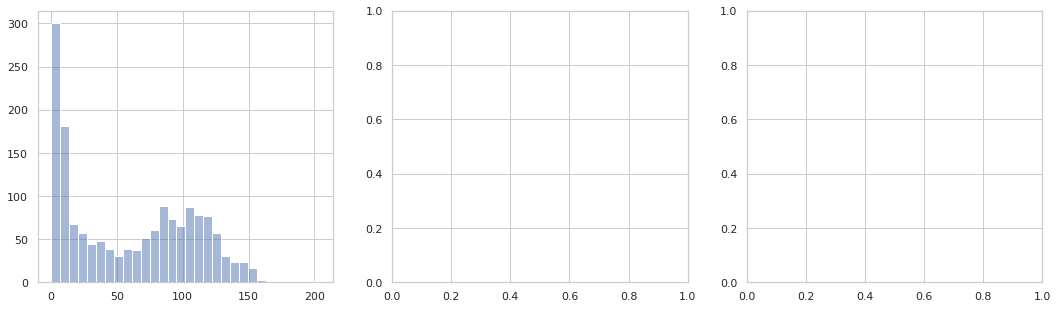

In [21]:
sns.set(style = "whitegrid")
fig, axes = plt.subplots(1, 3, figsize = (18, 5))

# Histogram for 'In'
sns.histplot(WongAvery_Merged_df['In'], bins = 30, ax = axes[0], kde = True)
axes[0].set_title('Distribution of In Counts')

# Histogram for 'Out'
sns.histplot(WongAvery_Merged_df['Out'], bins = 30, ax = axes[1], kde = True)
axes[1].set_title('Distribution of Out Counts')

# Histogram for 'In_Out_Diff'
sns.histplot(WongAvery_Merged_df['In_Out_Diff'], bins = 30, ax = axes[2], kde = True)
axes[2].set_title('Distribution of In-Out Difference')

plt.tight_layout()
plt.show()

# Descriptive Statistics
descriptive_stats = WongAvery_Merged_df[['In', 'Out', 'In_Out_Diff']].describe()
print(descriptive_stats)

In [ ]:
quarters = {
    'Fall': {'start': '2022-09-19', 'end': '2022-12-10'},
    'Winter': {'start': '2023-01-04', 'end': '2023-03-15'},
    'Spring': {'start': '2023-03-29', 'end': '2023-06-16'}
}

def assign_quarter(date, quarters):
    for quarter, dates in quarters.items():
        if pd.to_datetime(dates['start']) <= date <= pd.to_datetime(dates['end']):
            return quarter

In [ ]:
WongAvery_Merged_EDA_df = WongAvery_Merged_df.copy()
WongAvery_Merged_EDA_df['hour'] = WongAvery_Merged_EDA_df['datetime'].dt.hour
WongAvery_Merged_EDA_df['day'] = WongAvery_Merged_EDA_df['datetime'].dt.day
WongAvery_Merged_EDA_df['month'] = WongAvery_Merged_EDA_df['datetime'].dt.month
WongAvery_Merged_EDA_df['quarter'] = WongAvery_Merged_EDA_df['datetime'].apply(lambda x: assign_quarter(x, quarters))

### Hourly Trend Analysis

In [ ]:
sns.lineplot(x='hour', y='In', hue='quarter', data=WongAvery_Merged_EDA_df, errorbar=None)
plt.title('Hourly Trend of IN')
plt.xlabel('Hour')
plt.ylabel('IN count')
plt.show()

In [ ]:
sns.lineplot(x='hour', y='Out', hue='quarter', data=WongAvery_Merged_EDA_df, errorbar=None)
plt.title('Hourly Trend of OUT')
plt.xlabel('Hour')
plt.ylabel('OUT count')
plt.show()

### Daily Trend Analysis

In [ ]:
daily_trends = WongAvery_Merged_EDA_df.groupby('day').mean()[['In', 'Out', 'In_Out_Diff']]

plt.figure(figsize = (12, 6))
plt.plot(daily_trends['In'], label = 'Number of people In')
plt.plot(daily_trends['Out'], label = 'Number of people Out')
plt.plot(daily_trends['In_Out_Diff'], label = 'In-Out Difference')
plt.title('Average Daily In/Out Trends of WongAvery Library')
plt.xlabel('Day')
plt.ylabel('Counts')
plt.legend()

daily = plt.gcf()
daily.show()

### Monthly Data Analysis

In [ ]:
monthly_trends = WongAvery_Merged_EDA_df.groupby('month').mean()[['In', 'Out', 'In_Out_Diff']]

plt.figure(figsize = (12, 6))
plt.plot(monthly_trends['In'], label = 'Number of people In')
plt.plot(monthly_trends['Out'], label = 'Number of people Out')
plt.plot(monthly_trends['In_Out_Diff'], label = 'In-Out Difference')
plt.title('Average Monthly In/Out Trends of WongAvery Library')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.legend()

monthly = plt.gcf()
monthly.show()

### Quarterly Data Analysis

In [ ]:
quarterly_trends = WongAvery_Merged_EDA_df.groupby('quarter').mean()[['In', 'Out', 'In_Out_Diff']]

plt.figure(figsize = (10, 4))
plt.plot(quarterly_trends['In'], label = 'Number of people In')
plt.plot(quarterly_trends['Out'], label = 'Number of people Out')
plt.plot(quarterly_trends['In_Out_Diff'], label = 'In-Out Difference')
plt.title('Average Quarterly In/Out Trends of WongAvery Library')
plt.xlabel('Quarter')
plt.ylabel('Counts')
plt.legend()

quarterly = plt.gcf()
quarterly.show()

We will now perform EDA within a quarter instead of looking at trends by quarters.

### Quarter Data Analysis

In [ ]:
fall_range = (WongAvery_Merged_df['datetime'] >= '2022-09-19') & (WongAvery_Merged_df['datetime'] <= '2022-12-10')
winter_range = (WongAvery_Merged_df['datetime'] >= '2023-01-04') & (WongAvery_Merged_df['datetime'] <= '2023-03-15')
spring_range = (WongAvery_Merged_df['datetime'] >= '2023-03-29') & (WongAvery_Merged_df['datetime'] <= '2023-06-16')

fall_df = WongAvery_Merged_df[(WongAvery_Merged_df['datetime'] >= '2022-09-19') & (WongAvery_Merged_df['datetime'] <= '2022-12-10')]
winter_df = WongAvery_Merged_df[(WongAvery_Merged_df['datetime'] >= '2023-01-04') & (WongAvery_Merged_df['datetime'] <= '2023-03-15')]
spring_df = WongAvery_Merged_df[(WongAvery_Merged_df['datetime'] >= '2023-03-29') & (WongAvery_Merged_df['datetime'] <= '2023-06-16')]

In [ ]:
#Distribution for Fall Quarter
sns.histplot(fall_df['In'], bins = 30, kde = True)
plt.title('Fall Quarter - Distribution of In Counts')
plt.show()

sns.histplot(fall_df['Out'], bins=30, kde=True)
plt.title('Fall Quarter - Distribution of Out Counts')
plt.show()

sns.histplot(fall_df['In_Out_Diff'], bins=30, kde=True)
plt.title('Fall Quarter - Distribution of In-Out Difference')
plt.show()

In [ ]:

#Fall Quarter Hourly Trend
fall_df['hour'] = fall_df['datetime'].dt.hour
hourly_trends_fall = fall_df.groupby('hour').mean()[['In', 'Out', 'In_Out_Diff']]

plt.figure(figsize = (12, 6))
plt.plot(hourly_trends_fall['In'], label = 'In')
plt.plot(hourly_trends_fall['Out'], label = 'Out')
plt.title('Fall Quarter - Hourly Trends')
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.legend()

fall_hourly = plt.gcf()
fall_hourly.show()

In [ ]:

#Fall Quarter Daily Trend
fall_df['day'] = fall_df['datetime'].dt.day
daily_trends_fall = fall_df.groupby('day').mean()[['In', 'Out', 'In_Out_Diff']]

plt.figure(figsize = (12, 6))
plt.plot(daily_trends_fall['In'], label = 'In')
plt.plot(daily_trends_fall['Out'], label = 'Out')
plt.title('Fall Quarter - Daily Trends')
plt.xlabel('Day')
plt.ylabel('Counts')
plt.legend()

fall_daily = plt.gcf()
fall_daily.show()

In [ ]:

#Fall Quarter Weekly Trend
fall_df['week'] = fall_df['datetime'].dt.isocalendar().week
weekly_trends = fall_df.groupby('week').mean()[['In', 'Out', 'In_Out_Diff']]

weekly_trends.plot(kind = 'line', figsize = (12, 6))
plt.title('Fall Quarter - Weekly Trends')
plt.xlabel('Week Number')
plt.ylabel('Counts')
plt.legend()

fall_weekly = plt.gcf()
fall_weekly.show()

In [ ]:

#Fall Quarter Monthly Trend
fall_df['month'] = fall_df['datetime'].dt.month
monthly_trends_fall = fall_df.groupby('month').mean()[['In', 'Out', 'In_Out_Diff']]

plt.figure(figsize = (12, 6))
plt.plot(monthly_trends_fall['In'], label = 'In')
plt.plot(monthly_trends_fall['Out'], label = 'Out')
plt.title('Fall Quarter - Monthly Trends')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.legend()

fall_monthly = plt.gcf()
fall_monthly.show()


In [ ]:

print(fall_df[['In', 'Out', 'In_Out_Diff']].describe())

In [ ]:
fall_df['date'] = fall_df['datetime'].dt.date
daily_data = fall_df.groupby('date').agg({'In': 'sum', 'Out': 'sum', 'In_Out_Diff': 'sum'})

daily_data.plot(kind = 'line', figsize = (15, 6))
plt.title('Fall Quarter - Daily Trends')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend()

daily_trend_sum_fall = plt.gcf()
daily_trend_sum_fall.show()

# Ethics & Privacy


- Informed consent

    I think that the data our team collected both the weather data and the traffic accident data from a trusted pubblic website,the official San Diego government website.
- Collection bias.

    The weather and traffic accident data are all observed events, and the data collected is more focued on the facts that happened instead of subjective observation. The factual focused data could help us reduce collection bias.
- Limit PII exposure

    Our data, though collected from various person and events, do not contain much personally identifiable information, there are no obvious part in our data that can lead to identification of certain indivisual.
- Downstream bias mitigation

    The data we are using are collected comprehensively thoughout all the traffic accidents rigardless of their race, gender or religious backgrounds.
-  Data security

    Since the data are public accessible, our job of keeping our own data safe is to make our repo private and only grant access to relative indivisuals.
- Right to be forgotten

    We'll open a contact portal to the public so that if anyone feels they wish to have their data removed, they have the freedom to do so.
- Data retention plan

    We plan on delete the data we've collected after week 10
- Missing perspectives

    We plan on talking to the TA and possibly the professor about our assumption to collect another point of view.
- Dataset bias

    The dataset is collected by the San Diego government through factual events e.g. weather, temperature, the number and the type of traffic accidents that happened. In conclusion, I think our dataset is mostly bias free, but we can't rule out the bias created by the observer of the event. e.g police officer's view on an accident,
- Honest representation

    we will try our best in representing the data without any bias
- Privacy in analysis

    We will insure that data with PII are not used or displayed unless necessary for the analysis
- Auditability

    We will insure that any analysis we conclude will be reasonable and reproducible

# Team Expectations 


Read over the [COGS108 Team Policies](https://github.com/COGS108/Projects/blob/master/COGS108_TeamPolicies.md) individually. Then, include your group’s expectations of one another for successful completion of your COGS108 project below. Discuss and agree on what all of your expectations are. Discuss how your team will communicate throughout the quarter and consider how you will communicate respectfully should conflicts arise. By including each member’s name above and by adding their name to the submission, you are indicating that you have read the COGS108 Team Policies, accept your team’s expectations below, and have every intention to fulfill them. These expectations are for your team’s use and benefit — they won’t be graded for their details.

* **Team Expectation 1: Communication**
  * We will use the designated Discord chat for project-related communication and be responsive to the best of our abilities to ensure that every group member is on the same page.
  * We understand that members might be unable to attend certain meetings due to other responsibilities. If that happens, they should notify the rest of the group before the scheduled meeting.
  
* **Team Expectation 2: Scheduled Meetings**
  * All group members are expected to attend the scheduled meeting in the Project Timeline.
  * Other meetings not on the timeline can also be scheduled if necessary.
* **Team Expectation 3: Team Contribution**
  * Although project sections will be divided based on individual strengths, everyone should contribute to some degree.
* **Team Expectation 4: Quality Assurance**
  * All major project sections should be reviewed before submission.
* **Team Expectation 5: Uncooperative Group Member**
  * In the case that a group member refuses to complete their assigned task, the rest of the group will notify them of that and give them a time frame to improve and show change.
  * If there is no change shown, the professor will have to be notified.
* **Team Expectation 6: Accountability**
  * All members are expected to equally contribute to the project by completing their assigned responsibilities. 
  * If any member is facing difficulty completing their portion, they should bring it up to the team to receive help.


# Project Timeline Proposal



| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 10/23  |  7:30 PM | Determine method of communication and weekly meeting time going forward  | Discuss and decide on research topic; research databases for ideal datasets; begin general background research | 
| 10/30  |  8 PM |  Each member provide one dataset for topic; continue with general background research | Discuss project proposal; draft project proposal; complete responsible section | 
| 11/6  | 8 PM  | Finalize and submit proposal; receieve feedback and continue to edit proposal accordingly  | Discuss data wrangling and cleaning for dataset |
| 11/15  | 8 PM  | Import & Wrangle Data (`La Jolla 2022/3.csv`, `Gate Counters.csv`) | Update hypothesis, copy sections from proposal to checkpoint |
| 11/20  | 8 PM  | Finalize wrangling of both datasets; Begin Analysis, Add visualizations | Discuss/edit Analysis; Add.remove data visualization; Discuss ethics and privacy |
| 11/27  | 8 PM  | Complete analysis; Finalize visualizations; Receive feedback | Discuss/edit full project and improvement ideas based off feedback received; Start working on project video demonstration |
| 12/13  | Before 11:59 PM | Finalize project; Finalize project video | Turn in Final Project components & Group Project Surveys |